# Specific Test V. Exploring transformers
The following notebook is my solution for Specific Test V

In [1]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [188]:
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
# import pytorch_lightning as pl
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
from sklearn.metrics import r2_score, mean_squared_error
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from collections import OrderedDict
from torchvision import transforms
from torchvision.datasets import ImageFolder
from PIL import Image
from transformers import ViTConfig, ViTForImageClassification, ViTImageProcessor, TrainingArguments, Trainer
from datasets import load_dataset
from transformers import DefaultDataCollator
import evaluate
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, RocCurveDisplay

# Loading the dataset.

I use huggingface datasets to load, split and preprocess the dataset. The ViTImagePeocessor converts the data into required patches 

In [195]:
dataset = load_dataset("imagefolder", data_dir="lenses")

Resolving data files:   0%|          | 0/10000 [00:00<?, ?it/s]

Found cached dataset imagefolder (/root/.cache/huggingface/datasets/imagefolder/default-67de58bf6bf06b78/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/1 [00:00<?, ?it/s]

In [196]:
dataset = dataset['train'].train_test_split(test_size=0.1, seed = 10)

Loading cached split indices for dataset at /root/.cache/huggingface/datasets/imagefolder/default-67de58bf6bf06b78/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f/cache-25dee24a4a0ac521.arrow and /root/.cache/huggingface/datasets/imagefolder/default-67de58bf6bf06b78/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f/cache-15afa40eedc287f3.arrow


In [197]:
mapping = {0:"no_sub", 1:"sub"} 

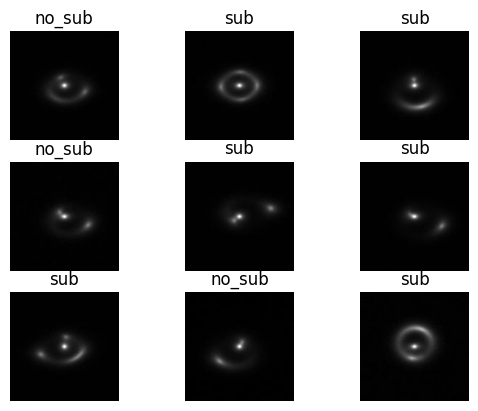

In [199]:
for i in range(9):
    idx = np.random.randint(9000)
    plt.subplot(3,3,i+1)
    plt.imshow(dataset['train'][idx]['image'], cmap = "gray")
    plt.title(mapping[dataset['train'][idx]['label']])
    plt.axis("off")

In [175]:
train_labels = dataset['train']['label']
test_labels = dataset['test']['label']

In [176]:
def transform_images(examples):
    examples["pixel_values"] = [transforms.ToTensor()(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

In [177]:
dataset = dataset.with_transform(transform_images)

In [178]:
data_collator = DefaultDataCollator()

In [179]:
vit_extractor =  ViTImageProcessor(resample="PIL.Image.BOX", do_normalize=True, size={"height":100, "width":100})

In [180]:
accuracy = evaluate.load("accuracy")

In [181]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

# Model training

I have used the ViTForImageClassification provided by huggingface. In this experiment, I have not fine-tuned any pretrained model, rather trained a new one from scratch. The model has only 3 hidden layers and attention heads. Since the dataset is very domain specific, we do not need a lot of attention heads and hidden layers, and are still able to achieve good accuracy, AUC and ROC.  

In [132]:
vit_config = ViTConfig(hidden_size = 256*3, num_hidden_layers = 3, num_attention_heads = 3, intermediate_size = 1024, image_size = 150)

In [133]:
model = ViTForImageClassification(vit_config)

In [134]:
training_args = TrainingArguments(
    output_dir="vit_for_lenses",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=20,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
)


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [135]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=vit_extractor,
    compute_metrics=compute_metrics,
)

In [136]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 9000
  Num Epochs = 20
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 4
  Total optimization steps = 2800
  Number of trainable parameters = 12477698


Epoch,Training Loss,Validation Loss,Accuracy
0,0.690500,0.715968,0.495000
1,0.681500,0.641434,0.590000
2,0.518800,0.556982,0.670000
3,0.679600,0.559158,0.713000
4,0.292900,0.294492,0.854000
5,0.240600,0.232646,0.883000
6,0.249700,0.203791,0.905000
7,0.208900,0.191876,0.915000
8,0.297000,0.125474,0.945000
9,0.143400,0.205398,0.911000


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 16
Saving model checkpoint to my_awesome_food_model/checkpoint-140
Configuration saved in my_awesome_food_model/checkpoint-140/config.json
Model weights saved in my_awesome_food_model/checkpoint-140/pytorch_model.bin
Image processor saved in my_awesome_food_model/checkpoint-140/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 16
Saving model checkpoint to my_awesome_food_model/checkpoint-280
Configuration saved in my_awesome_food_model/checkpoint-280/config.json
Model weights saved in my_awesome_food_model/checkpoint-280/pytorch_model.bin
Image processor saved in my_awesome_food_model/checkpoint-280/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 16
Saving model checkpoint to my_awesome_food_model/checkpoint-420
Configuration saved in my_awesome_food_model/checkpoint-420/config.json
Model weights saved in my_awesome_food_model/chec

TrainOutput(global_step=2800, training_loss=0.2399110677173095, metrics={'train_runtime': 430.266, 'train_samples_per_second': 418.346, 'train_steps_per_second': 6.508, 'total_flos': 9.094220454924e+17, 'train_loss': 0.2399110677173095, 'epoch': 19.99})

# Metrics


In [193]:
predicted_probab = F.softmax(torch.Tensor(trainer.predict(dataset['test'])[0]), dim = 1)[:,1]

***** Running Prediction *****
  Num examples = 1000
  Batch size = 16


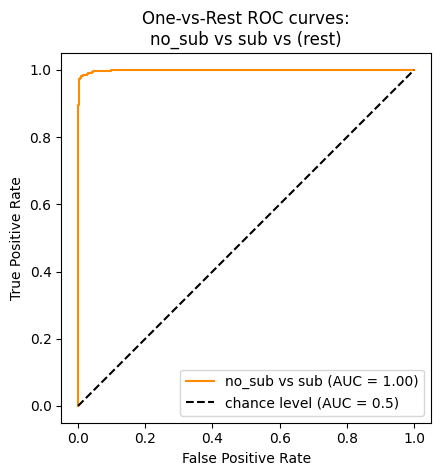

In [194]:
display = RocCurveDisplay.from_predictions(
    test_labels,
    predicted_probab,
    name=f"no_sub vs sub",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"One-vs-Rest ROC curves:\nno_sub vs sub vs (rest)")
plt.legend()